In [1]:
import keras
import os

#from params import get_params
from sklearn import preprocessing
import sklearn.preprocessing
import numpy as np

import matplotlib.pyplot as plt

from keras.models import Model, load_model
from keras.preprocessing import image
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input

from PIL import Image, ImageOps

import pickle

Using TensorFlow backend.


In [2]:
conv_base = VGG16(weights='imagenet',
                  include_top=True,
                  input_shape=(224, 224, 3))

conv_base.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [3]:
seed = 13
np.random.seed(seed)

In [5]:
from keras import models
from keras import layers 

# Remove top layer and connect custom dense layer
fc2 = conv_base.get_layer('fc2').output

Drop1 = layers.Dropout(0.8, seed = seed)(fc2)
Dense1 = layers.Dense(13, activation='sigmoid',name='mypredictions')(Drop1)

model = Model(inputs=conv_base.input, outputs = Dense1)

In [6]:
train_dir = "classifier/training"
validation_dir = "classifier/validation"
batch_size=20

In [8]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
      #rescale=1./255,
      width_shift_range=0.1,
      height_shift_range=0.1,
      shear_range=0.1,
      rotation_range=8,
      brightness_range=(0.2,1.5),
      fill_mode='nearest'
      )

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator()#rescale=1./255

train_generator = train_datagen.flow_from_directory(
        # This is the target directory
        train_dir,
        # All images will be resized to 150x150
        target_size=(224, 224),
        batch_size=batch_size,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(224, 224),
        batch_size=batch_size,
        class_mode='categorical')

Found 1911 images belonging to 13 classes.
Found 477 images belonging to 13 classes.


In [9]:
print(train_generator.class_indices)

{'mercat_independencia': 9, 'societat_general': 11, 'desconegut': 3, 'farmacia_albinyana': 7, 'ajuntament': 0, 'mnactec': 10, 'escola_enginyeria': 5, 'masia_freixa': 8, 'castell_cartoixa': 1, 'dona_treballadora': 4, 'catedral': 2, 'teatre_principal': 12, 'estacio_nord': 6}


In [10]:
conv_base.trainable = True

#set_trainable = False
#for layer in conv_base.layers:
#    if layer.name == 'fc2':
#        set_trainable = True
#    if set_trainable:
#        layer.trainable = True
#    else:
#        layer.trainable = False

In [11]:
from keras import optimizers

model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.Adam(lr=1e-5),
              metrics=['acc'])

In [16]:
model.layers[0].trainable

False

In [17]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [20]:
filepath ='Model/Prueba/Test_12.h5'

In [21]:
checkpoint = keras.callbacks.ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True,
                                             save_weights_only=False, mode='auto', period=1)

In [22]:
callbacks_list = [checkpoint]

In [23]:
history = model.fit_generator(
      train_generator,
      steps_per_epoch= 1911 // batch_size, #images from train = 2150
      epochs=20,
      validation_data=validation_generator,
      callbacks = callbacks_list,
      validation_steps= 477 // batch_size) #images from validation = 477

Epoch 1/20
95/95 [==============================] - 117s 1s/step - loss: 2.4921 - acc: 0.2074 - val_loss: 1.9713 - val_acc: 0.4217

Epoch 00001: val_acc improved from -inf to 0.42174, saving model to Model/Prueba/Test_12.h5
Epoch 2/20
95/95 [==============================] - 84s 889ms/step - loss: 1.8520 - acc: 0.4023 - val_loss: 1.1326 - val_acc: 0.5470

Epoch 00002: val_acc improved from 0.42174 to 0.54705, saving model to Model/Prueba/Test_12.h5
Epoch 3/20
95/95 [==============================] - 80s 839ms/step - loss: 1.2018 - acc: 0.6267 - val_loss: 0.7376 - val_acc: 0.8053

Epoch 00003: val_acc improved from 0.54705 to 0.80525, saving model to Model/Prueba/Test_12.h5
Epoch 4/20
95/95 [==============================] - 80s 839ms/step - loss: 0.7989 - acc: 0.7584 - val_loss: 0.5224 - val_acc: 0.8534

Epoch 00004: val_acc improved from 0.80525 to 0.85339, saving model to Model/Prueba/Test_12.h5
Epoch 5/20
95/95 [==============================] - 80s 838ms/step - loss: 0.5922 - acc: 

In [16]:
model.save('Model/8_test_prueba.h5')

In [24]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

In [25]:
list_acc = []
list_val_acc = []
list_loss = []
list_val_loss = []

In [26]:
list_acc.append(acc)
list_val_acc.append(val_acc)
list_loss.append(loss)
list_val_loss.append(val_loss)

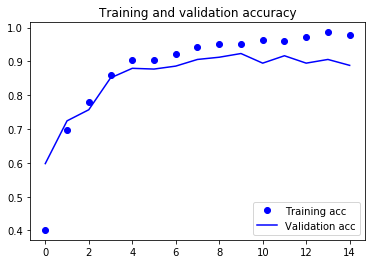

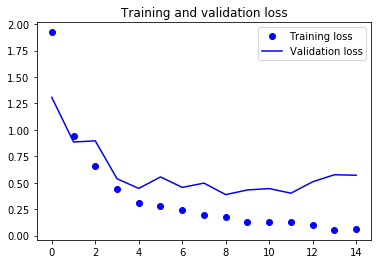

In [16]:
import matplotlib.pyplot as plt


epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()